In [1]:
import pandas as pd
import warnings

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')

In [8]:
# Loading user behavior cognition datasets

def get_new_feature_name_df(old_feature_name_df) :
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
                                                                                           if x[1] >0 else x[0] ,  axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset() :
    feature_name_df = pd.read_csv('../../dataset/UCI_HAR_Dataset/features.txt', sep='\s+',
                                  header=None, names=['column_index','column_name'])
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()

    X_train = pd.read_csv('../../dataset/UCI_HAR_Dataset/train/X_train.txt', sep='\s+',
                                                names=feature_name)
    X_test = pd.read_csv('../../dataset/UCI_HAR_Dataset/test/X_test.txt', sep='\s+',
                                                names=feature_name)
    y_train = pd.read_csv('../../dataset/UCI_HAR_Dataset/train/y_train.txt', sep='\s+',
                                                header=None, names=['action'])
    y_test = pd.read_csv('../../dataset/UCI_HAR_Dataset/test/y_test.txt', sep='\s+',
                                                header=None, names=['action'])

    return X_train, X_test, y_train, y_test



In [9]:
# Separate with learning/test data and learn/predict/evaluate with random forest
X_train, X_test, y_train, y_test = get_human_dataset()

rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)
pred= rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print("RandomForestClassifier accuracy : {0}".format(accuracy))

RandomForestClassifier accuracy : 0.9219545300305395


In [4]:
# Cross-validation and hyper parameter tuning with GridSearchCV

params = {
    'n_estimators':[100],
    'max_depth' : [6, 8, 10, 12],
    'min_samples_leaf' : [8, 12, 18 ],
    'min_samples_split' : [8, 16, 20]
}

rf_clf = RandomForestClassifier(n_jobs=-1)
grid_cv = GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('Best hyper parameter : \n', grid_cv.best_params_)
print('Best predict accuracy : {0}'.format(grid_cv.best_score_))

Best hyper parameter : 
 {'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 100}
Best predict accuracy : 0.9141730141458106


In [5]:
best_rf_clf = RandomForestClassifier(n_estimators=300, max_depth=8, min_samples_leaf=8, min_samples_split=20)
best_rf_clf.fit(X_train, y_train)
pred = best_rf_clf.predict(X_test)

In [6]:
print('Accuracy : {0}'.format(accuracy_score(y_test, pred)))


Accuracy : 0.9202578893790295


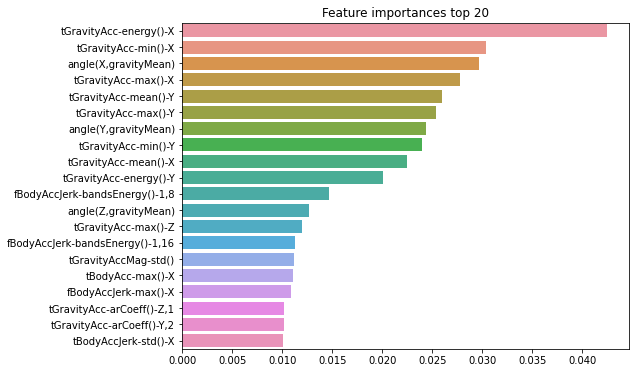

In [7]:
# Visualization

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = best_rf_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_test.columns)
ftr_top = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances top 20')
sns.barplot(x=ftr_top, y=ftr_top.index)
plt.show()

